# Exploratory Data Analysis Notebook
This notebook will preprocess and leverage NLP models on the unstructured data to turn it into a usable feature space for modeling Tucker Carlson's body of work

In [3]:
#Imports cell

#Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import nltk
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
# import the tucker document data either as a CSV or a pickle
#Read out from CSV
tucker_docs = pd.read_csv('data/tucker_docs.csv', encoding='UTF8', header = None).T
tucker_docs.head()

,0
0,Fox News host gives his take on pro-abortion ...
1,Fox News host reflects on the left's respons...
2,Fox News host gives his take on how Americans...
3,Fox News host gives his take on the Supreme C...
4,Fox News host gives his take on the real moti...


## preprocess function

In [5]:
#to stem or to lem? We will lem

wnl = WordNetLemmatizer()

def preprocessing(text):
    #step 1: delete all caps words
    t_d = re.sub(r'\b[A-Z]+\b', '', text)
    
    #step 2: tokenize
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenized_doc = nltk.regexp_tokenize(t_d, pattern)
    
    #step 3: lower all cases
    low_tokenized_doc = [word.lower() for word in tokenized_doc]
    
    #step 4: stop words
    stopwords_list = stopwords.words('english')
    stop_tokenized_doc = [word for word in low_tokenized_doc if word not in stopwords_list]
    
    #step 5: lem
    tokens = [wnl.lemmatize(word) for word in stop_tokenized_doc]
    
    return tokens

In [8]:
#Generate list of preprocessed Tucker Carlson episodes
tucker_list = tucker_docs[0].tolist()
new_list = []
for each_doc in tucker_list:
    new_list.append(preprocessing(each_doc))

In [9]:
#Instantiate IDF vectorizer to create vectorized array
vectorizer = TfidfVectorizer()
vect = vectorizer.fit_transform([' '.join(new_list[n]) for n in range(len(new_list))])
td_idf_df = pd.DataFrame(vect.toarray(), columns = vectorizer.get_feature_names())
td_idf_df.head()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,ab,abaca,aback,abandon,abandoned,abandoning,abandonment,abasement,abbott,...,zoomcall,zoomed,zoonotic,zot,zucker,zuckerberg,zuckerbucks,zvfcgesbfiy,zweig,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Fit the NMF topic generation model
from sklearn.decomposition import NMF
model = NMF(n_components = 10)
model.fit(td_idf_df)

# to get H
H = model.transform(td_idf_df) # transform document into topic vector representation

# to get W 
W = model.components_ # word component weights for each topic

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [11]:
#List out the top 10 words for each topic

for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['thing', 'year', 'see', 'new', 'state', 'would', 'yes', 'say', 'mean', 'want', 'get', 'thank', 'country', 'one', 'like', 'well', 'right', 'they', 'think', 'going', 'know', 'we', 'that', 're', 'people']


THE TOP 10 WORDS FOR TOPIC #1


/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['that', 'they', 'american', 'military', 'going', 'biden', 'sanction', 'would', 'weapon', 'nuclear', 'know', 'united', 'invasion', 'energy', 'president', 'state', 'we', 're', 'vladimir', 'ukrainian', 'war', 'putin', 'russian', 'russia', 'ukraine']


THE TOP 10 WORDS FOR TOPIC #2
['function', 'gain', 'boogeyman', 'really', 'lab', 'said', 'look', 'wuhan', 'people', 'celebrate', 'public', 'infection', 'know', 'science', 'virus', 'scientist', 'pandemic', 'immunity', 'research', 'anthony', 'email', 'dr', 'christmas', 'tony', 'fauci']


THE TOP 10 WORDS FOR TOPIC #3
['mandate', 'crime', 'terrorism', 'biden', 'justice', 'violence', 'department', 'teach', 'education', 'terrorist', 'people', 'like', 'meeting', 're', 'they', 'domestic', 'teacher', 'merrick', 'kid', 'garland', 'mask', 'child', 'board', 'parent', 'school']


THE TOP 10 WORDS FOR TOPIC #4
['hunter', 'state', 'vice', 'would', 'way', 'going', 'thing', 'administration', 'he', 'carlson', 'democratic', 'year', 'unity', 'that', 'like', '

In [16]:
%%capture topic_word_plot
#Visualize the 10 topics



def plot_top_words(W, feature_names, n_top_words, title, n_topics):
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model", 10)

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


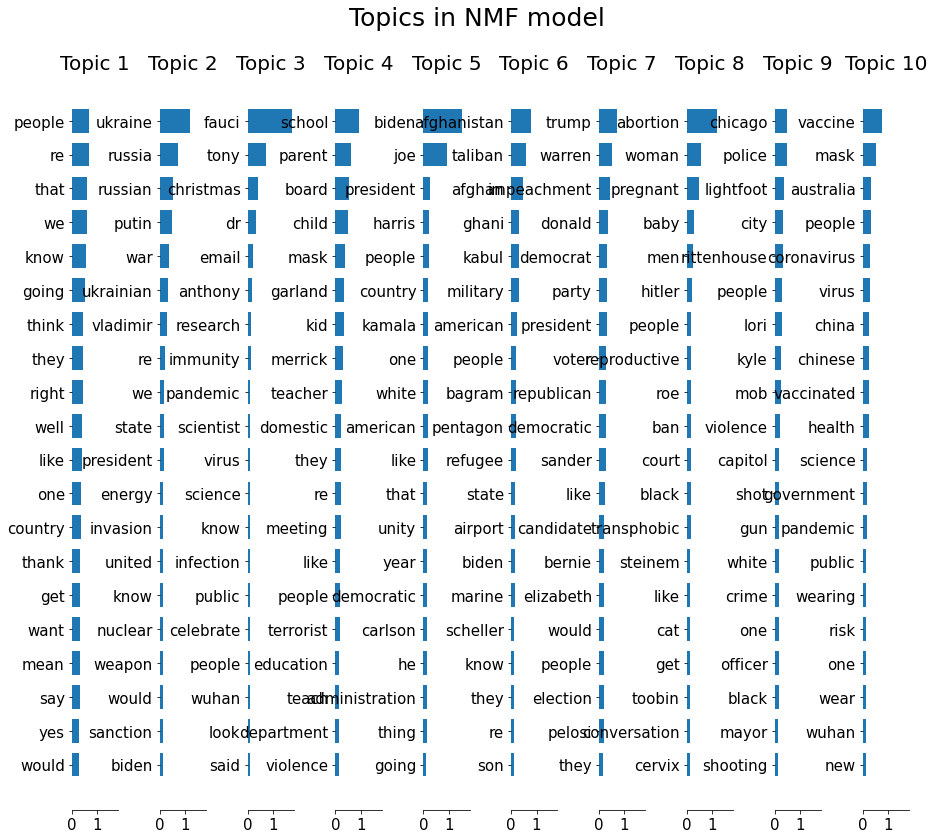

In [17]:
topic_word_plot()

In [18]:
#Manually re-assign topics
topic = {0: 'American Politics', 1: 'War in Ukraine', 2: 'Covid-19', 3: 'School', 4: 'Biden Administration', 
         5: 'War in Afghanistan', 6: 'Trump', 7: 'Abortion', 8: 'Kyle Rittenhouse Shooting', 
         9: 'Covid-19 Vaccine' }

## Process the Twitter data

In [19]:
def twitter_preprocessing(text):

    #Step 0
    #This is Praveen's code
    text = text.lower()
    text = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+@[A-Z0-9_]+|#[A-Z0-9_]+|http\S+", "", text).strip().replace("\r", "").replace("\n", "").replace("\t", "")
   
    #step 1: delete all caps words
    t_d = re.sub(r'\b[A-Z]+\b', '', text)

    #step 2: tokenize
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenized_doc = nltk.regexp_tokenize(t_d, pattern)

    #step 3: stop words
    stopwords_list = stopwords.words('english')
    stop_tokenized_doc = [word for word in tokenized_doc if word not in stopwords_list]

    #step 4: lem
    tokens = [wnl.lemmatize(word) for word in stop_tokenized_doc]
    return ' '.join(tokens)

In [60]:
#Load the twitter data
tweet_df = pd.read_csv('data/unique_tweets_list.csv').drop(columns = ['Unnamed: 0'])

In [61]:
import ast

#Function library
def string_to_list(s):
    try:
        l = ast.literal_eval(s)
    except:
        l = None
    return l

def prepare_tweets(tweet_row):

    try:
        tweet_list = []
        for n in range(len(tweet_row)):
            tweet_list.append(twitter_preprocessing(tweet_row[n]))

        cleaned_tweets = []
        for tweet in tweet_list:
            if len(tweet) > 20:
                cleaned_tweets.append(tweet)
        return cleaned_tweets
    except:
        return None

In [62]:
#Turn pandas string-list view into literal list
tweet_df['tweet_history'] = tweet_df['tweet_history'].apply(lambda x: string_to_list(x))
tweet_df = tweet_df.dropna()
#Preprocess the tweets
tweet_df['cleaned_tweets'] = tweet_df['tweet_history'].apply(lambda x: prepare_tweets(x))

#Vectorize the tweets
tweet_df['vectorized'] = tweet_df['cleaned_tweets'].apply(lambda x: vectorizer.transform(x))

In [63]:
#Fit the NMF topic generation model

# to get H
H_list = []

for n in range(len(tweet_df)):
    try:
        H_list.append(model.transform(tweet_df['vectorized'][n])) # transform document into topic vector representation
    except:
        H_list.append(None)
        continue;

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(
/Users/danielbradley/opt/anaconda3/lib/python3.8/site-p

In [64]:
#List out the topic weights
topic_weights = []

for n in range(0, len(tweet_df)):
    topic_weights.append(list(pd.DataFrame(H_list[n], columns = list(topic.values())).mean()))

In [65]:
twitter_weights_df = pd.DataFrame(topic_weights,  columns = list(topic.values()))

In [66]:
#Generate tucker carlson distribution
tucker_weights_df = pd.DataFrame(model.transform(td_idf_df), columns = list(topic.values())).mean()

In [46]:
from scipy import spatial


spatial.distance.cosine(np.array(twitter_weights_df.iloc[0,:]), np.array(tucker_weights_df.iloc[:]))

0.14130991379375812

In [42]:
np.array(twitter_weights_df.iloc[0,:])

array([0.00717069, 0.00256343, 0.00124541, 0.00767376, 0.00357917,
       0.0025098 , 0.01037323, 0.00506563, 0.00264698, 0.0023184 ])

In [45]:
np.array(tucker_weights_df.iloc[:])

array([0.05214063, 0.02117701, 0.01118431, 0.01693804, 0.02636801,
       0.0152955 , 0.03196556, 0.01223921, 0.02798836, 0.03075664])

In [129]:
full_twitter_df = twitter_weights_df.join(tweet_df[['tweet_history', 'cleaned_tweets']])
full_twitter_df = full_twitter_df.dropna()

In [130]:
cosine_list = []
for n in range(len(twitter_weights_df)):
    tweet_vec = np.array(twitter_weights_df.iloc[n,:])
    tuck_vec = np.array(tucker_weights_df.iloc[:])
    cosine_list.append(1 - spatial.distance.cosine(tweet_vec, tuck_vec))

In [131]:
cosine_series = pd.Series(cosine_list)

In [132]:
full_twitter_df['tucker_similarity'] = cosine_series

In [164]:
#full_twitter_df = full_twitter_df.sort_values(by = 'tucker_similarity', ascending=False).reset_index()
full_twitter_df.iloc[-10:-1]

,level_0,index,American Politics,War in Ukraine,Covid-19,School,Biden Administration,War in Afghanistan,Trump,Abortion,Kyle Rittenhouse Shooting,Covid-19 Vaccine,tweet_history,cleaned_tweets,tucker_similarity
3646,3646,1914,0.003595,0.000007,0.000543,0.000565,0.000352,0.000000,0.001930,0.056948,0.001316,0.000000,[Miscarriage is very common in nature. It's ca...,[miscarriage common nature called spontaneous ...,0.205044
3647,3647,1339,0.004357,0.000699,0.003653,0.000000,0.000101,0.000461,0.001740,0.088082,0.001865,0.000392,[Y’all I can’t believe you decided to overturn...,[believe decided overturn roe v wade really cl...,0.196085
3648,3648,2074,0.002408,0.001634,0.000373,0.001164,0.000467,0.001052,0.000997,0.082340,0.002109,0.002413,[RT @IpasOrg: Barriers to birth control–and ab...,[rt barrier birth control abortion fall harder...,0.195135
3649,3649,3520,0.000000,0.000000,0.000000,0.001990,0.000000,0.000000,0.000000,0.068061,0.003854,0.004935,[@pissedoffmuggle I was misinformed in that re...,[misinformed regard law redrafted birth contro...,0.191373
3650,3650,2186,0.001563,0.000091,0.000092,0.001784,0.000574,0.001707,0.003039,0.073555,0.000417,0.001482,[@marcorubio \nCodify Roe v Wade. \nWhy wasn’t...,[codify roe v wade done long time ago excuse v...,0.190840
3651,3651,616,0.001433,0.000295,0.000545,0.002630,0.001543,0.000548,0.001448,0.078467,0.002576,0.000942,"[""The protesters should never have been allowe...",[protester never allowed gather anywhere near ...,0.190426
3652,3652,3159,0.001549,0.000565,0.000525,0.001539,0.000390,0.000374,0.001793,0.076531,0.000668,0.001094,[Check out #FloridaVoiceForTheUnborn Executive...,[check floridavoicefortheunborn executive dire...,0.180036
3653,3653,1804,0.003086,0.000222,0.000634,0.001928,0.000380,0.000349,0.000791,0.116208,0.001201,0.001167,[Now moreso than ever before is the time to fu...,[moreso ever time fund local grassroots aborti...,0.173618
3654,3654,3149,0.000000,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.149109,0.000000,0.000000,[@Morning_Joe I have a question. Since there a...,[question since law state banning abortion tel...,0.142228


In [193]:
#Manually labeled predictions
itemized_cats_like_tucker = [1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 
                             1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

itemized_cats_dislike_tucker = [0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
                                0, 0, 1, 1, 0, 0, 0, 0, 0, 1]

#True values (Top 20 like tucker, top 20 unlike tucker)
itemized_cats_like_tucker_true = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
                                  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

itemized_cats_dislike_tucker_false = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tucker_pred = np.array(itemized_cats_like_tucker + itemized_cats_dislike_tucker)
tucker_true = np.array(itemized_cats_like_tucker_true + itemized_cats_dislike_tucker_false)

#full_twitter_df['tweet_history'][3636]



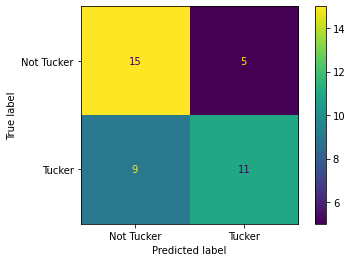

In [205]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

conf_mat = confusion_matrix(tucker_true, tucker_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Not Tucker', 'Tucker'])
disp.plot();

In [207]:
print(classification_report(tucker_true, tucker_pred))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68        20
           1       0.69      0.55      0.61        20

    accuracy                           0.65        40
   macro avg       0.66      0.65      0.65        40
weighted avg       0.66      0.65      0.65        40

